<a href="https://colab.research.google.com/github/LeslyVictoria2/CSST106-CS4B/blob/main/4B_VICTORIA_EXER4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CSST106 - Perception and Computer Vision**
##**EXERCISE 4**
###**Lesly-Ann B. Victoria from BSCS-4B**

#### **Exercise 1: HOG (Histogram of Oriented Gradients) Object Detection**

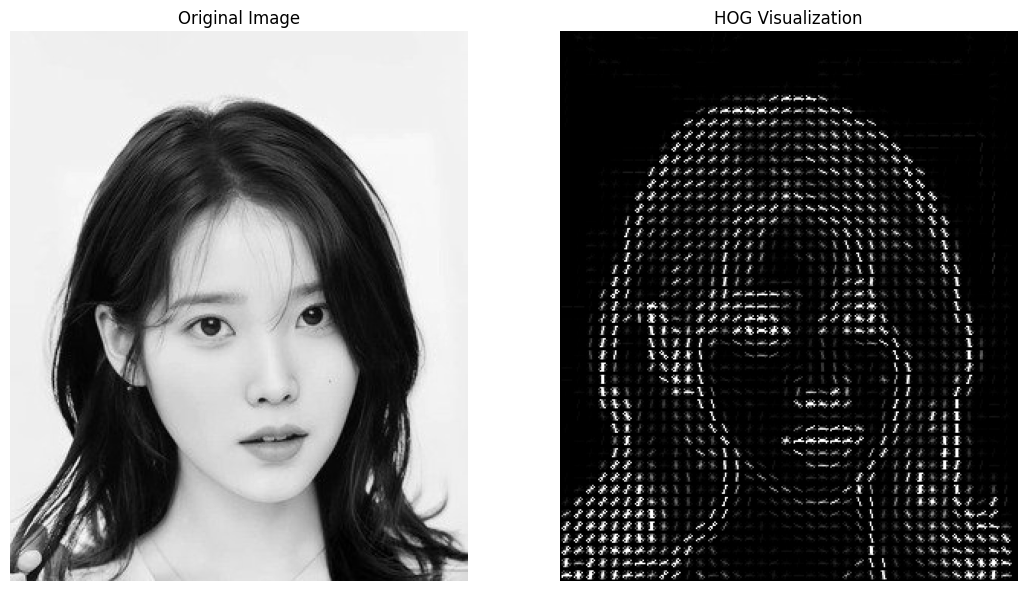

In [35]:
#Import Libraries.
import cv2
from skimage import feature, exposure
import matplotlib.pyplot as plt
import numpy as np

#Load the image.
image_path = '/content/drive/MyDrive/iu.jpg'
image = cv2.imread(image_path)
if image is None:
    raise ValueError("Image not found at the specified path.")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#Convert the image to grayscale.
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

#Apply HOG descriptor to extract features.
hog_features, hog_image = feature.hog(
    gray_image,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    block_norm='L2-Hys',
    visualize=True
)

#Adjust the intensity of the HOG image for better visualization.
hog_image = exposure.rescale_intensity(hog_image, in_range=(0, 15))

#Visualize the original and HOG image.
plt.figure(figsize=(13, 10))

#Display the original image.
plt.subplot(1, 2, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

#Display the HOG visualization image.
plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.axis('off')

plt.show()

#### **Exercise 2: YOLO (You Only Look Once) Object Detection**

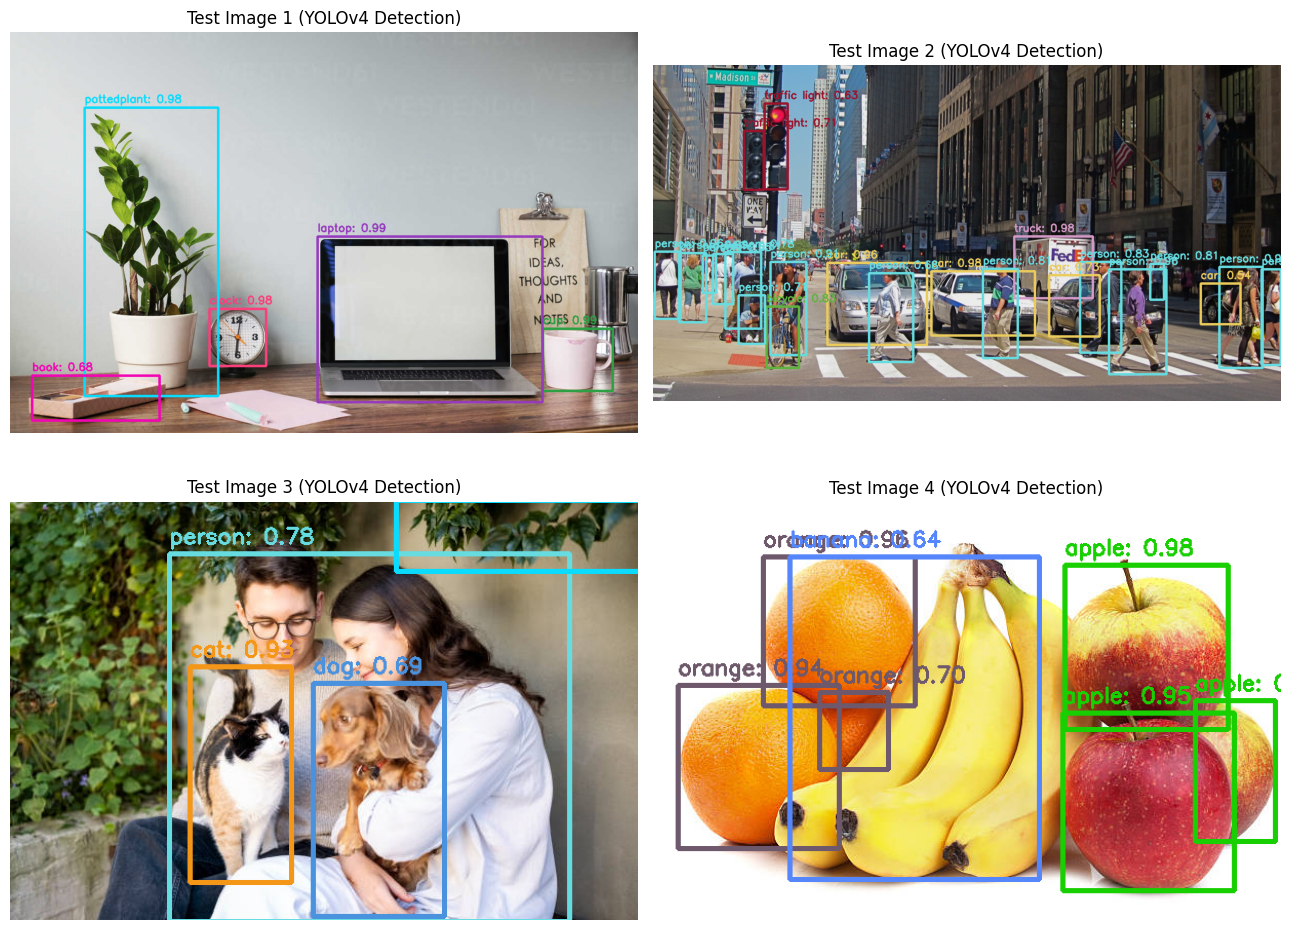

In [38]:
#Import Libraries.
import cv2
import numpy as np
import matplotlib.pyplot as plt

#Set the paths to YOLOv4 configuration, weights, and coco.names files.
cfg_path = '/content/drive/MyDrive/YOLOv4/yolov4.cfg'
weights_path = '/content/drive/MyDrive/YOLOv4/yolov4.weights'
names_path = '/content/drive/MyDrive/YOLOv4/coco.names'

#Load the COCO class labels.
with open(names_path, 'r') as f:
    classes = [line.strip() for line in f.readlines()]

#Generate a random color for each class.
np.random.seed(42)
colors = np.random.randint(0, 255, size=(len(classes), 3), dtype='uint8')

#Load Pre-trained YOLOv4 model.
net = cv2.dnn.readNet(cfg_path, weights_path)

#Set up YOLOv4 layer names.
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers().flatten()]

#Define a function for object detection.
def detect_objects(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found at the specified path: {image_path}")

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width = image.shape[:2]

    #Preprocess the image for YOLOv4.
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)

    #Perform forward pass and get detection results.
    detections = net.forward(output_layers)

    #Initialize lists for detected bounding boxes, confidences, and class IDs.
    boxes = []
    confidences = []
    class_ids = []

    #Process detections.
    for detection in detections:
        for obj in detection:
            scores = obj[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > 0.5:
                center_x = int(obj[0] * width)
                center_y = int(obj[1] * height)
                w = int(obj[2] * width)
                h = int(obj[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                #Append box, confidence, and class ID to lists.
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    #Apply Non-Maximum Suppression to remove overlapping boxes.
    indices = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=0.5, nms_threshold=0.4)

    #Draw bounding boxes and labels on the image with thicker lines and larger text.
    for i in indices.flatten():
        x, y, w, h = boxes[i]
        color = [int(c) for c in colors[class_ids[i]]]
        label = f"{classes[class_ids[i]]}: {confidences[i]:.2f}"

        cv2.rectangle(image_rgb, (x, y), (x + w, y + h), color, 3)
        cv2.putText(image_rgb, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

    return image_rgb

#Multiple images to test the model.
image_paths = [
    '/content/drive/MyDrive/YOLOv4/office.jpg',
    '/content/drive/MyDrive/YOLOv4/crosswalk.JPG',
    '/content/drive/MyDrive/YOLOv4/animals.jpg',
    '/content/drive/MyDrive/YOLOv4/fruits.jpg'
]

#Visualize the boidung boxes and class labels.
plt.figure(figsize=(13, 10))

for i, path in enumerate(image_paths, 1):
    detected_image = detect_objects(path)
    plt.subplot(2, 2, i)
    plt.imshow(detected_image)
    plt.axis('off')
    plt.title(f"Test Image {i} (YOLOv4 Detection)")

plt.tight_layout()
plt.show()

#### **Exercise 3: SSD (Single Shot MultiBox Detector) with TensorFlow**

In [18]:
#Install Libraries.
!pip install tensorflow tensorflow-hub opencv-python matplotlib

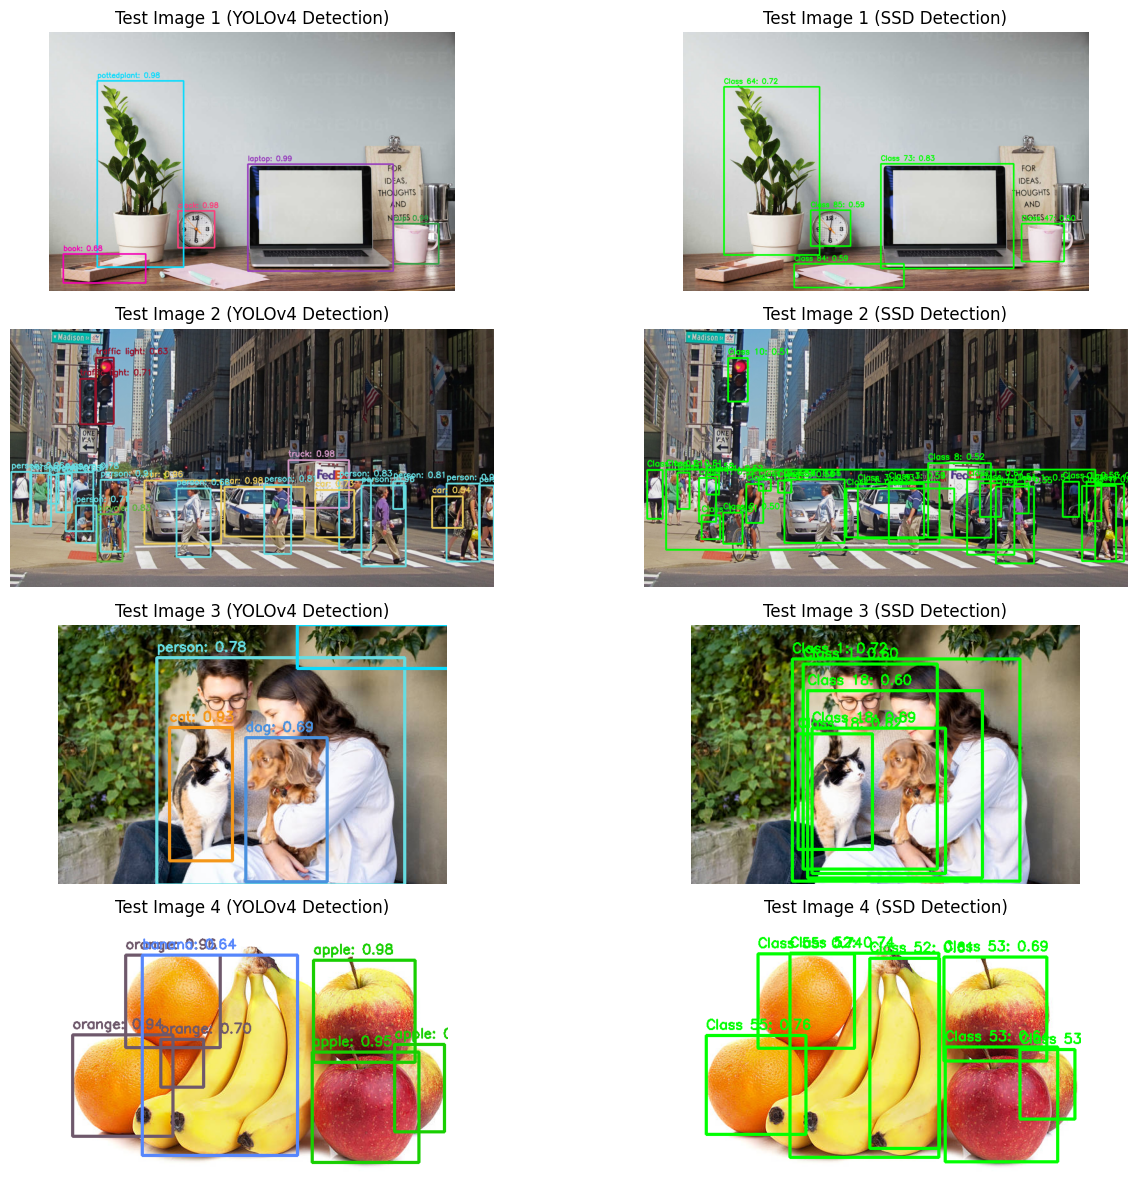

In [39]:
#Import Libraries.
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import numpy as np
import matplotlib.pyplot as plt

#Load the SSD model from TensorFlow Hub.
ssd_model = hub.load("https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2")

def detect_objects_ssd(image_path):
    #Load image.
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found at the specified path: {image_path}")

    #Convert to RGB.
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width = image.shape[:2]

    #Preprocess image for SSD model.
    input_tensor = tf.image.resize(image_rgb, (300, 300))
    input_tensor = tf.cast(input_tensor, dtype=tf.uint8)  #Convert to uint8.
    input_tensor = tf.expand_dims(input_tensor, axis=0)  #Add batch dimension.

    #Perform SSD detection.
    detections = ssd_model(input_tensor)

    #Extract results.
    detection_boxes = detections['detection_boxes'][0].numpy()
    detection_scores = detections['detection_scores'][0].numpy()
    detection_classes = detections['detection_classes'][0].numpy().astype(int)

    #Define confidence threshold.
    confidence_threshold = 0.5

    #Draw bounding boxes on the image.
    for i in range(len(detection_scores)):
        if detection_scores[i] >= confidence_threshold:
            box = detection_boxes[i]
            y_min, x_min, y_max, x_max = int(box[0] * height), int(box[1] * width), int(box[2] * height), int(box[3] * width)

            #Draw bounding box and label.
            cv2.rectangle(image_rgb, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)
            label = f"Class {detection_classes[i]}: {detection_scores[i]:.2f}"
            cv2.putText(image_rgb, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    return image_rgb

#Multiple images to test SSD and compare with YOLO.
image_paths = [
    '/content/drive/MyDrive/YOLOv4/office.jpg',
    '/content/drive/MyDrive/YOLOv4/crosswalk.JPG',
    '/content/drive/MyDrive/YOLOv4/animals.jpg',
    '/content/drive/MyDrive/YOLOv4/fruits.jpg'
]

#Visualization.
plt.figure(figsize=(14, 12))

for i, path in enumerate(image_paths, 1):
    #YOLO detection.
    yolo_detected_image = detect_objects(path)

    #SSD detection.
    ssd_detected_image = detect_objects_ssd(path)

    #Display YOLO result.
    plt.subplot(len(image_paths), 2, 2 * i - 1)
    plt.imshow(yolo_detected_image)
    plt.axis('off')
    plt.title(f"Test Image {i} (YOLOv4 Detection)")

    #Display SSD result.
    plt.subplot(len(image_paths), 2, 2 * i)
    plt.imshow(ssd_detected_image)
    plt.axis('off')
    plt.title(f"Test Image {i} (SSD Detection)")

plt.tight_layout()
plt.show()

#### **Exercise 4: Traditional vs. Deep Learning Object Detection Compariso**

In [41]:
#HOG-SVM Implementation
#Import Libraries.
import cv2
import matplotlib.pyplot as plt
import time

#Initialize HOG descriptor with default people detector.
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

def detect_objects_hog(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found at the specified path: {image_path}")

    #Convert image to grayscale.
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #Start timing.
    start_time = time.time()

    #Detect people in the image using HOG-SVM.
    (rects, weights) = hog.detectMultiScale(image_gray, winStride=(4, 4), padding=(8, 8), scale=1.05)

    #End timing.
    end_time = time.time()
    hog_time = end_time - start_time

    #Draw bounding boxes.
    for (x, y, w, h) in rects:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    print(f"HOG-SVM detection completed in {hog_time:.4f} seconds for {image_path}.")
    return image, hog_time

In [42]:
#SSD Implementation
def detect_objects_ssd(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found at the specified path: {image_path}")

    #Convert image to grayscale.
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width = image.shape[:2]

    #Resize image to 300x300, expected by SSD model, and keep it as uint8.
    input_tensor = tf.image.resize_with_pad(image_rgb, 300, 300)
    input_tensor = tf.cast(input_tensor, dtype=tf.uint8)
    input_tensor = tf.expand_dims(input_tensor, axis=0)

    #Start timing.
    start_time = time.time()

    #Run SSD model.
    detections = ssd_model(input_tensor)

    #End timing.
    end_time = time.time()
    ssd_time = end_time - start_time

    #Extract detection results.
    detection_boxes = detections['detection_boxes'][0].numpy()
    detection_scores = detections['detection_scores'][0].numpy()
    detection_classes = detections['detection_classes'][0].numpy().astype(int)

    #Set a confidence threshold.
    confidence_threshold = 0.5

    #Draw bounding boxes on the image.
    for i in range(len(detection_scores)):
        if detection_scores[i] >= confidence_threshold:
            box = detection_boxes[i]
            y_min, x_min, y_max, x_max = int(box[0] * height), int(box[1] * width), int(box[2] * height), int(box[3] * width)
            cv2.rectangle(image_rgb, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)
            label = f"Class {detection_classes[i]}: {detection_scores[i]:.2f}"
            cv2.putText(image_rgb, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    print(f"SSD detection completed in {ssd_time:.4f} seconds for {image_path}.")
    return image_rgb, ssd_time

HOG-SVM detection completed in 2.2975 seconds for /content/drive/MyDrive/YOLOv4/office.jpg.
SSD detection completed in 0.0915 seconds for /content/drive/MyDrive/YOLOv4/office.jpg.
HOG-SVM detection completed in 1.9794 seconds for /content/drive/MyDrive/YOLOv4/crosswalk.JPG.
SSD detection completed in 0.0891 seconds for /content/drive/MyDrive/YOLOv4/crosswalk.JPG.
HOG-SVM detection completed in 0.4624 seconds for /content/drive/MyDrive/YOLOv4/animals.jpg.
SSD detection completed in 0.0924 seconds for /content/drive/MyDrive/YOLOv4/animals.jpg.
HOG-SVM detection completed in 0.4578 seconds for /content/drive/MyDrive/YOLOv4/fruits.jpg.
SSD detection completed in 0.1020 seconds for /content/drive/MyDrive/YOLOv4/fruits.jpg.


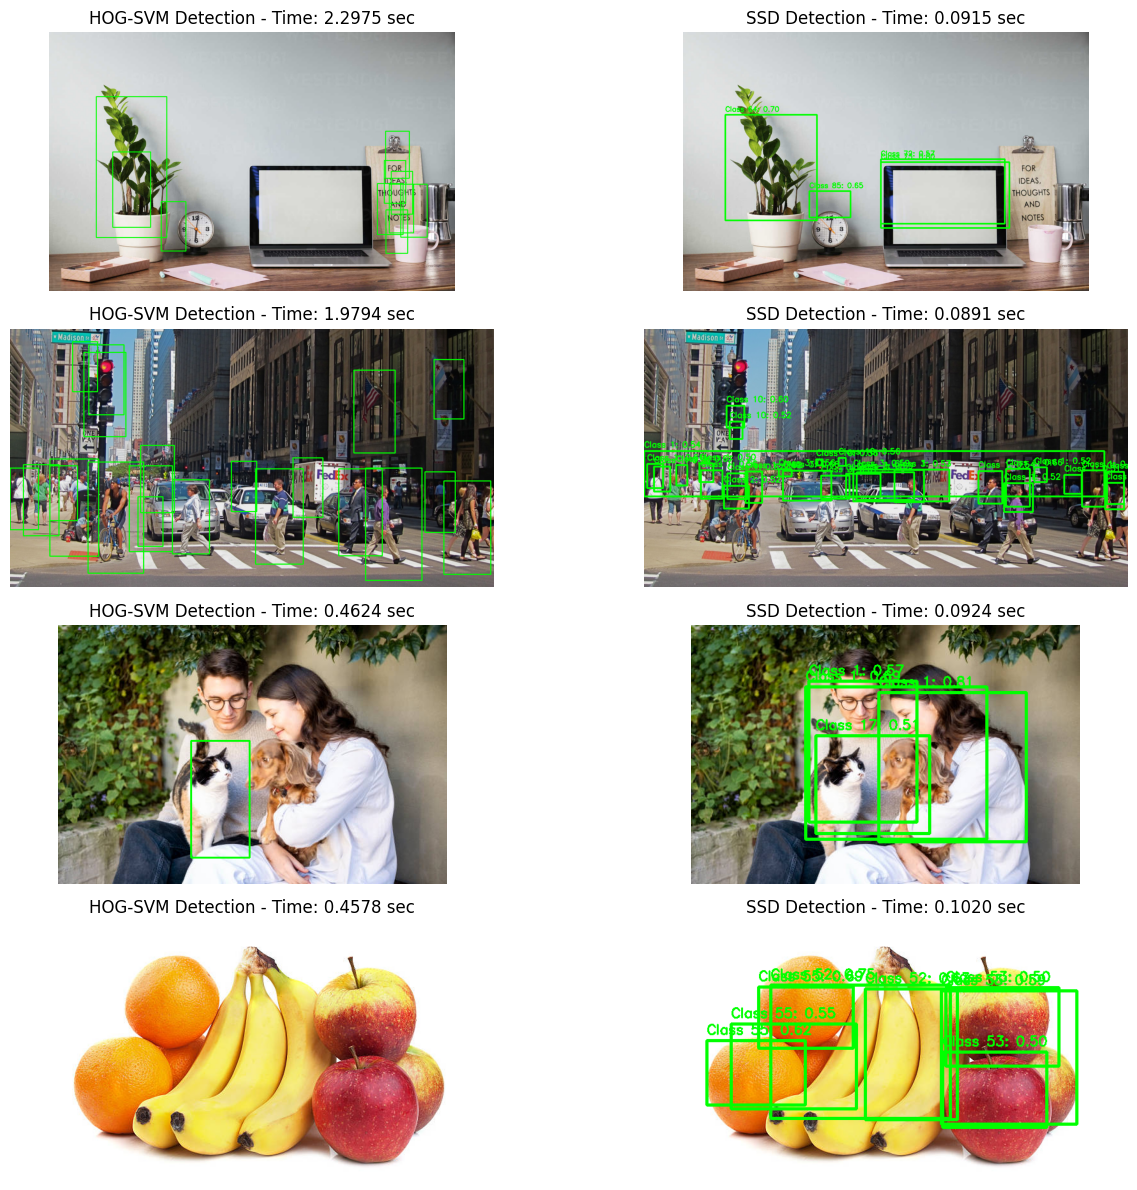

In [43]:
#Multiple images to test HOG-SVM and SSD.
image_paths = [
    '/content/drive/MyDrive/YOLOv4/office.jpg',
    '/content/drive/MyDrive/YOLOv4/crosswalk.JPG',
    '/content/drive/MyDrive/YOLOv4/animals.jpg',
    '/content/drive/MyDrive/YOLOv4/fruits.jpg'
]

#Visualization.
plt.figure(figsize=(14, 12))

for i, path in enumerate(image_paths, 1):
    #HOG-SVM detection.
    hog_detected_image, hog_time = detect_objects_hog(path)

    #SSD detection.
    ssd_detected_image, ssd_time = detect_objects_ssd(path)

    #Display HOG-SVM result.
    plt.subplot(len(image_paths), 2, 2 * i - 1)
    plt.imshow(cv2.cvtColor(hog_detected_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"HOG-SVM Detection - Time: {hog_time:.4f} sec")

    #Display SSD result.
    plt.subplot(len(image_paths), 2, 2 * i)
    plt.imshow(ssd_detected_image)
    plt.axis('off')
    plt.title(f"SSD Detection - Time: {ssd_time:.4f} sec")

plt.tight_layout()
plt.show()